# Demonstrating methylize regression and plotting

In [1]:
import numpy as np
import pandas as pd
import math
import time
import methylprep
import methylcheck

In [9]:
%load_ext autoreload
%autoreload 2
from methylize import diff_meth_pos, volcano_plot, manhattan_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Install joblib module for parallelization
import sys
!conda install --yes --prefix {sys.prefix} joblib

Solving environment: done

# All requested packages already installed.



In [11]:
dir()

['In',
 'Out',
 '_',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'diff_meth_pos',
 'exit',
 'get_ipython',
 'manhattan_plot',
 'math',
 'methylcheck',
 'methylize',
 'methylprep',
 'np',
 'os',
 'pd',
 'quit',
 'sys',
 'time',
 'volcano_plot']

In [12]:
# load a processed dataset and the phenotype list per sample.
# in CLI I ran `python -m methylprep process -d GSE69852_copy --betas --m_value to make these files.
betas = pd.read_pickle('data/GSE69852_beta_values.pkl')
m_values = pd.read_pickle('data/GSE69852_m_values.pkl')
betas.head()
#m_values.head()

,9247377093_R02C01,9247377093_R03C01,9247377093_R06C02,9247377085_R04C02,9247377093_R05C01,9247377093_R02C02
IlmnID,,,,,,
cg00035864,0.236234,0.287561,0.318016,0.308176,0.239339,0.161795
cg00061679,0.427194,0.395514,0.456510,0.525169,0.523010,0.549533
cg00063477,0.929039,0.927137,0.940222,0.932739,0.930215,0.931468
cg00121626,0.481058,0.357316,0.328793,0.330045,0.403873,0.313132
cg00223952,0.044029,0.040062,0.038420,0.022201,0.027155,0.022284


## Testing logistic regression

In [13]:
##Create a logistic regression dataset using strings that will later be converted to zeros and ones
test_pheno_data = ["fetal","fetal","fetal","adult","adult","adult"]

In [14]:
test_M_values_T = m_values.transpose()
test_M_values_T

IlmnID,cg00035864,cg00061679,cg00063477,cg00121626,cg00223952,cg00243321,cg00271873,cg00272582,cg00308367,cg00311963,...,cg27572240,cg27576692,cg27603882,cg27604249,cg27610821,cg27614706,cg27619353,cg27620176,cg27647370,cg27652464
9247377093_R02C01,-1.657558,-0.396044,4.145929,-0.077822,-4.422725,1.428067,0.887213,-4.277830,3.444005,-0.069623,...,-5.723271,4.989842,-5.625227,2.630148,1.878921,4.999150,-2.224928,5.723168,5.544820,-4.371885
9247377093_R03C01,-1.272171,-0.585133,4.040560,-0.819236,-4.566209,1.650368,-0.130788,-4.179360,3.519842,0.041774,...,-5.781331,5.496960,-5.629285,2.870655,1.898206,5.135388,-2.098986,5.976650,4.862443,-4.761151
9247377093_R06C02,-1.068828,-0.229694,4.415733,-1.005097,-4.630842,1.485471,-0.410473,-3.654502,3.541137,-0.293482,...,-5.740904,5.840322,-5.795193,3.462553,2.273422,4.845416,-2.198372,5.820837,5.923393,-4.222713
9247377085_R04C02,-1.134419,0.172425,4.186749,-1.002444,-5.443880,0.583537,1.346416,-4.212176,3.414862,0.007094,...,-5.810003,3.203422,-5.570827,1.337832,-2.171884,4.452098,-0.996283,5.720355,2.831669,-4.534927
9247377093_R05C01,-1.635230,0.160366,4.071644,-0.541178,-5.146184,0.754072,1.649216,-4.114014,3.273894,0.001541,...,-5.900220,3.536042,-5.749431,1.386635,-1.525328,4.256825,-1.127194,5.795570,2.736498,-4.738488
9247377093_R02C02,-2.339952,0.319934,4.262602,-1.106664,-5.433991,0.950332,1.703134,-4.199340,3.109885,-0.353469,...,-5.713091,3.795702,-5.495856,1.278621,-0.966895,4.292308,-1.357735,5.718294,2.757395,-5.130338


In [15]:
##Run a logistic regression on the methylation data, testing a random 30000 probes only here 
test_results = diff_meth_pos(test_M_values_T.sample(30000, axis=1), #.iloc[:,64000:67000],
                                  test_pheno_data,
                                  regression_method="logistic",
                            export=True)

Additional parameters: {'export': True}
All samples with the phenotype (fetal) were assigned a value of 0 and all samples with the phenotype (adult) were assigned a value of 1 for the logistic regression analysis.



1955 probes failed the logistic regression analysis due to perfect separation and could not be included in the final results.
14 probes failed the logistic regression analysis due to encountering a LinAlgError: Singular matrix and could not be included in the final results.
Probes with LinAlgError:
cg01747969
cg25270844
cg00924459
cg19866040
cg02518546
cg01209023
cg08553467
cg05116002
cg24390932
cg23392845
cg15144453
cg16035780
cg18022769
cg00647232
saved DMP_28031_6_2019-10-31.


## Testing Manhattan plot visualizations

NaNs: 1802
Total probes to plot: 26229
CH-01 2529 | CH-02 1865 | CH-03 1323 | CH-04 1113 | CH-05 1280 | CH-06 1912 | CH-07 1614 | CH-08 1121 | CH-09 543 | CH-10 1293 | CH-11 1479 | CH-12 1365 | CH-13 700 | CH-14 828 | CH-15 806 | CH-16 1239 | CH-17 1473 | CH-18 327 | CH-19 1477 | CH-20 583 | CH-21 241 | CH-22 460 | CH-X 636 | CH-Y 22
p-value line: 0.8860566476931632
saved manhattan_26229_2019-10-31.png


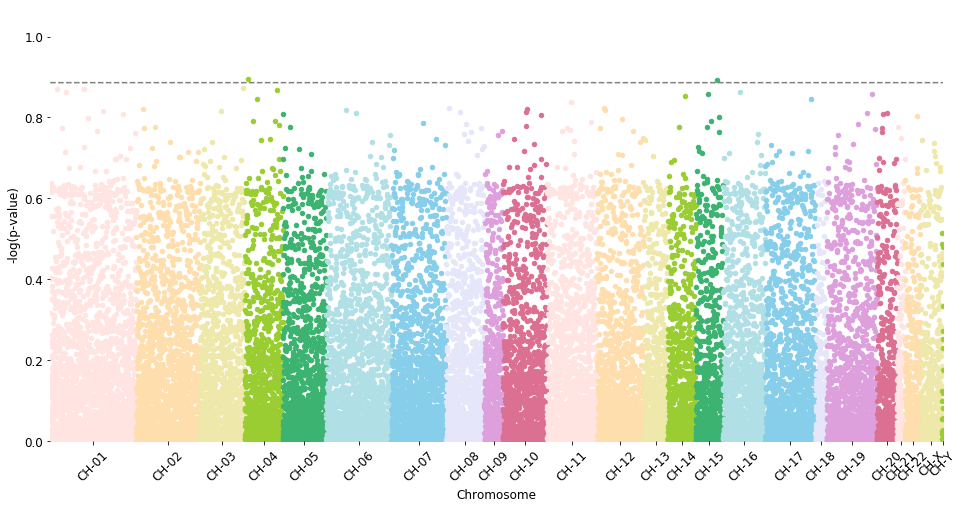

In [16]:
manhattan_plot(test_results, cutoff=0.13, palette='default', save=True)

In [17]:
""" pvalues: diff bw the two phenotype labels (A vs B difference sig)
most p-values in the demo data are not near or below 0.05.
That means those probes / locations are not useful in separating the two phenotypes
"""
interesting_probes = test_results[test_results['PValue'] <= 0.13]
interesting_probes

,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue,minuslog10pvalue,chromosome
cg03447013,4.742858,3.110382,0.127297,-1.353378,10.839094,0.999997,0.895181,CH-04
cg02423618,6.000645,3.939373,0.127697,-1.720384,13.721674,0.999997,0.893821,CH-15


## Testing linear regression

In [18]:
# usually you would pull this data from methylprep meta_data dataframe
# Create a linear regression dataset using strings that will be coerced to numbers (adult ages are estimates, not exact)
test_pheno_data2 = ["0","0","0","52","54","57"]

In [24]:
# Run a linear regression on the methylation data versus age of sample
test_results2 = diff_meth_pos(test_M_values_T, #.iloc[:,:], # ALL probes. slow!
                              test_pheno_data2,
                              regression_method="linear")

In [25]:
interesting_probes = test_results2[test_results2['PValue'] <= 0.05]
print(len(interesting_probes))
interesting_probes.head()

104037


,Coefficient,StandardError,PValue,95%CI_lower,95%CI_upper,FDR_QValue
cg08271842,0.036649,0.000243,2.448775e-10,0.036023,0.037274,0.000119
cg12699647,0.081730,0.000773,1.436808e-09,0.079742,0.083717,0.000233
cg23165623,-0.089640,0.000837,1.342041e-09,-0.091790,-0.087490,0.000233
cg11841771,-0.093945,0.000975,2.278438e-09,-0.096450,-0.091440,0.000255
cg00088844,-0.067228,0.000762,3.536345e-09,-0.069186,-0.065270,0.000255


Total probes to plot: 455018
CH-01 43198 | CH-02 32277 | CH-03 23526 | CH-04 19168 | CH-05 22774 | CH-06 33675 | CH-07 27533 | CH-08 19367 | CH-09 9063 | CH-10 22619 | CH-11 27049 | CH-12 23215 | CH-13 11649 | CH-14 14449 | CH-15 14567 | CH-16 20890 | CH-17 26680 | CH-18 5679 | CH-19 24381 | CH-20 9914 | CH-21 4067 | CH-22 8186 | CH-X 10711 | CH-Y 381
p-value line: 2.0


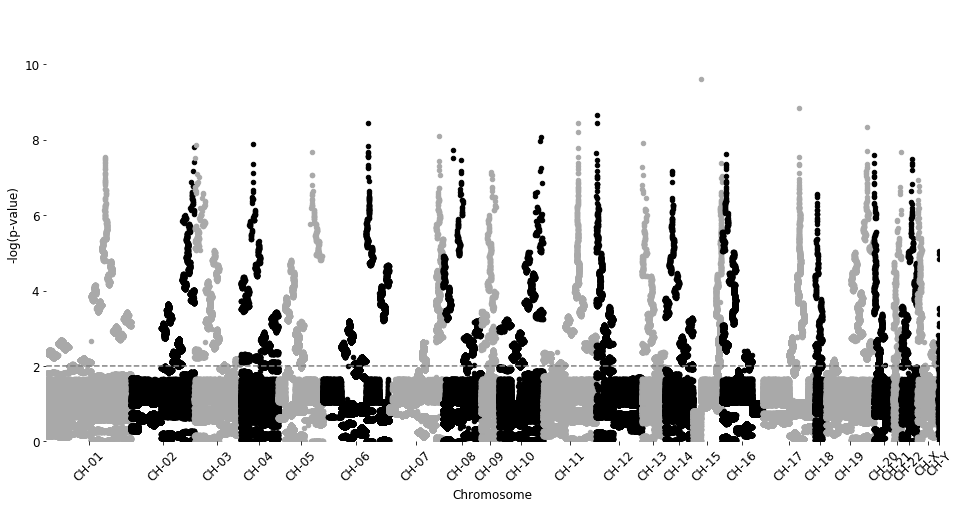

In [27]:
manhattan_plot(test_results2, cutoff=0.01, palette='Gray3', save=False)

## Testing Volcano plot visualizations

Excluded 1128 probes outside of the specified beta coefficient range: (-0.09, 0.09)
saved volcano_8872_2019-10-31.png


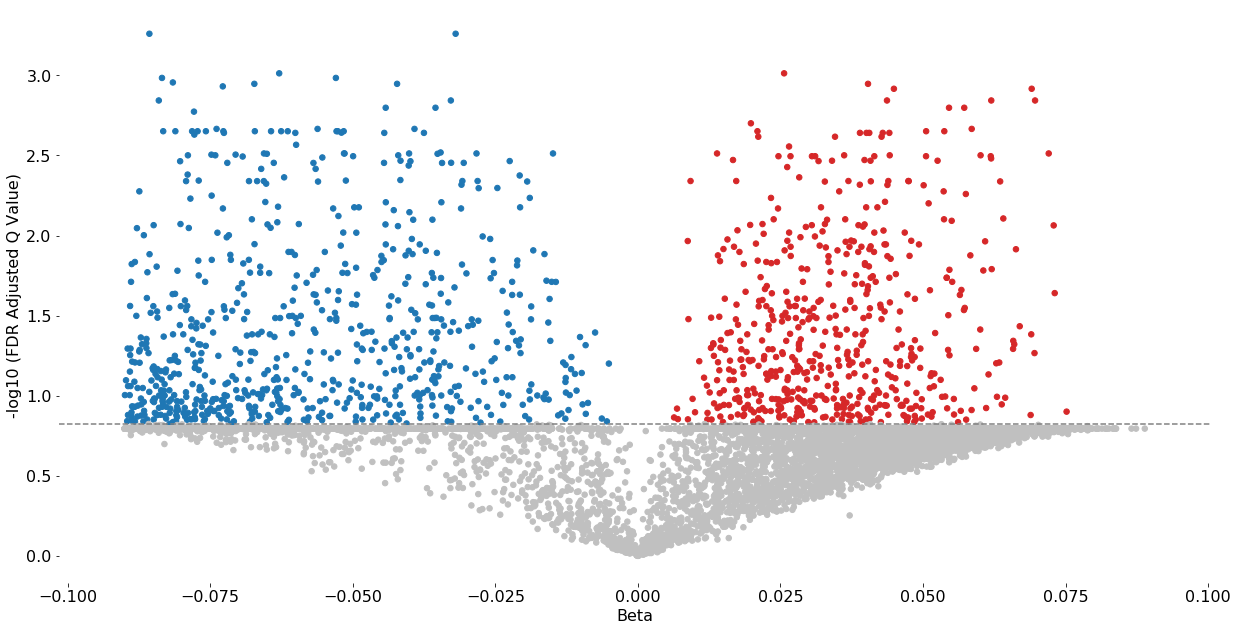

In [21]:
volcano_plot(test_results2, fontsize=16, cutoff=0.15, beta_coefficient_cutoff=(-0.09,0.09), save=True)